Initial Analysis
===

This notebook demonstrates loading in the data and doing basic analysis.

What do ORES predictions mean?  Can be hard to interpret...
 - See ORES documentation: https://www.mediawiki.org/wiki/ORES
 - English Wikipedia has filters based on the ORES score. See the "threshold ranges" here: https://en.wikipedia.org/wiki/Special:ORESModels
 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [53]:
# these three imports are aliased as np, pd, and plt by convention
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# other imports can go here
from datetime import datetime
from tqdm import tqdm

In [3]:
s = datetime.now()
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)
print(f"Read {len(df)} rows in {datetime.now() - s}.")
df.head()

Read 4766352 rows in 0:00:14.687382.


,rev_timestamp,page_id,rev_id,prev_rev_id,is_minor,user_text,user_id,seconds_to_prev,curr_bytes,delta_bytes,...,seconds_to_revert,damaging_pred,goodfaith_pred,model_version,user_is_bot,user_is_trusted,user_edit_count,page_rev_count,page_namespace,is_page_redirect
0,1546300800,47649229,876227289,869530001,True,BD2412,196446,3696519,1195,-9,...,None,0.021146,0.985808,0.4.0,False,False,1289980,5,118,0
1,1546300801,47642850,876227292,869530006,True,BD2412,196446,3696518,1423,-9,...,None,0.021847,0.983419,0.4.0,False,False,1289981,5,0,0
2,1546300801,59537875,876227290,None,False,Twozenhauer,14955567,None,7835,None,...,None,0.003826,0.998177,0.4.0,False,False,621,7,0,0
3,1546300801,60902958,876227291,869530004,True,BD2412,196446,3696519,1445,-9,...,None,0.021797,0.983336,0.4.0,False,False,1289980,30,0,0
4,1546300802,31392285,876227293,876069768,True,Cyberbot I,16266655,86401,125,-1,...,None,0.011582,0.992475,0.4.0,True,True,1006365,337,10,0


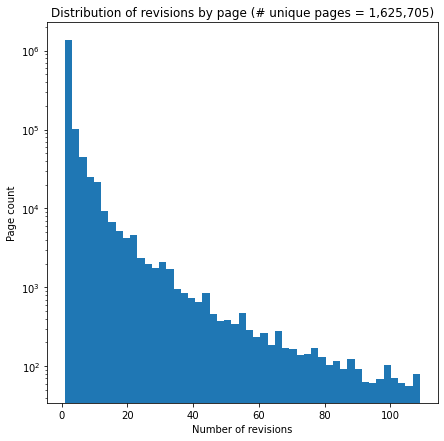

page_id
1952670     11547
47909226     6415
13784401     5696
5137507      4337
352651       4261
52527857     3965
11022716     3801
45316030     3310
34745517     3038
16927404     2463
Name: rev_id, dtype: int64

In [33]:
page_rev_counts = df.groupby('page_id').rev_id.nunique().sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
bins = np.linspace(1, np.quantile(page_rev_counts, 0.999))
ax.hist(page_rev_counts, bins=bins, log=True)
ax.set_title(f"Distribution of revisions by page (# unique pages = {df.page_id.nunique():,})")
ax.set_xlabel("Number of revisions")
ax.set_ylabel("Page count")

plt.show()
page_rev_counts.head(10)

In [47]:
df[df.is_reverted].revert_id

67         876373440
70         876290867
115        876233143
120        876269339
206        876231329
             ...    
4766335    881190768
4766340    881187915
4766342    881197530
4766344    881187572
4766346    881270612
Name: revert_id, Length: 460562, dtype: object

In [63]:
%time
revert_is_bot_map = {row.rev_id: row.user_is_bot for row in df[df.is_revert].itertuples()}
len(revert_is_bot_map)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 12.6 µs


321225

In [64]:
# for all reverted revisions, determine if it was reverted by a bot

# fast way
sdf = df[df.is_reverted]
is_reverting_user_a_bot = []
for row in tqdm(sdf.itertuples(), total=len(sdf)):
    if row.revert_id not in revert_is_bot_map:
        continue
    user_is_bot = revert_is_bot_map[row.revert_id]
    is_reverting_user_a_bot.append(user_is_bot)

# slow way
sdf = df[df.is_reverted]
is_reverting_user_a_bot = []
for row in tqdm(sdf.itertuples(), total=len(sdf)):
    res = df[df.rev_id == int(row.revert_id)]
    if len(res) != 1:
        continue
    user_is_bot = res.user_is_bot.iloc[0]
    is_reverting_user_a_bot.append(user_is_bot)


  2%|▏         | 8927/460562 [00:59<50:03, 150.39it/s]  


KeyboardInterrupt: 

In [4]:
# look at the columns and their inferred data types
df.dtypes

rev_timestamp                int64
page_id                      int64
rev_id                       int64
prev_rev_id                 object
is_minor                      bool
user_text                   object
user_id                     object
seconds_to_prev             object
curr_bytes                   int64
delta_bytes                 object
has_edit_summary              bool
is_reverted                   bool
is_revert                     bool
is_reverted_to_by_other       bool
is_self_reverted              bool
is_self_revert                bool
revert_target_id            object
revert_set_size             object
revert_id                   object
seconds_to_revert           object
damaging_pred              float64
goodfaith_pred             float64
model_version               object
user_is_bot                   bool
user_is_trusted               bool
user_edit_count              int64
page_rev_count               int64
page_namespace               int64
is_page_redirect    

In [45]:
df.page_namespace.value_counts()

0      3451557
3       307144
2       293384
1       237689
4       216112
14       87390
10       79089
5        22984
6        19942
15       19004
118       9119
11        8934
100       3905
828       3575
109       1610
7         1151
12         813
13         653
119        580
829        395
9          391
101        372
8          220
108        200
710        133
447          4
711          2
Name: page_namespace, dtype: int64

In [43]:
df.model_version.value_counts()

0.5.0    3681914
0.4.0    1017696
0.5.1      66742
Name: model_version, dtype: int64

In [38]:
df.user_id.value_counts().head()

None       840852
754619      66860
753665      61471
1215485     42742
7611264     32629
Name: user_id, dtype: int64

In [42]:
df[df.user_id == 'None'].user_text.sample(n=20)

2088384    2A00:23C4:1C2B:1000:4D73:BBDB:C74C:835B
2995677                               69.112.140.2
547084                               185.49.74.145
192071                              175.176.16.222
2767342       2001:579:8108:11:1C97:B2A6:5515:E668
3699003                             99.198.244.240
134831       2600:6C56:6508:1E7:10D:55B0:A444:C9E3
3454290     2001:BB6:4F12:3E58:8DF3:D260:1693:D323
3371396                             179.176.42.187
3409181           2409:4066:112:20BE:0:0:2ADA:A0A0
1450289        2405:205:3:3BAB:ECE7:F284:1C77:DF8B
2949432                             90.203.224.249
2676456    2407:7000:9601:D605:BD10:F72F:B345:A91C
3991218     2405:204:911A:B91D:E95A:4453:3D56:85FF
1809323                              98.206.114.61
2904362                              108.31.195.97
1244321                              97.85.118.142
911494        2601:484:180:12E:298B:6C4C:F06F:F569
2994358                              47.147.201.44
2913658     2601:603:4F80:10FE:

In [5]:
# how many revisions are made by bots?
df.user_is_bot.value_counts()

False    4241207
True      525145
Name: user_is_bot, dtype: int64

In [6]:
# what % of revisions are reverted?
pd.crosstab(df.user_is_bot, df.is_reverted, margins=True, normalize='index').round(decimals=3)

is_reverted,False,True
user_is_bot,,
False,0.898,0.102
True,0.950,0.050
All,0.903,0.097


In [7]:
# let's look only at the bot revisions
bdf = df[df.user_is_bot]
len(bdf)

525145

In [8]:
bdf.user_text.value_counts().head(20)

Cydebot                       42742
AnomieBOT                     32629
ClueBot NG                    28683
Pi bot                        28664
KolbertBot                    26762
EmausBot                      26685
InceptionBot                  20361
Citation bot                  18958
AAlertBot                     17941
ListeriaBot                   16025
Lowercase sigmabot III        15433
PrimeBOT                      15388
WOSlinkerBot                  14573
GreenC bot                    14540
Reports bot                   12839
RonBot                        11000
MediaWiki message delivery     9824
RMCD bot                       8873
AvicBot                        8413
HBC AIV helperbot5             8245
Name: user_text, dtype: int64

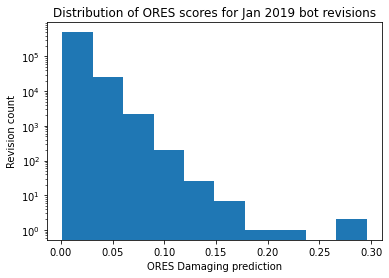

In [9]:
plt.hist(bdf.damaging_pred, log=True)
plt.title("Distribution of ORES scores for Jan 2019 bot revisions")
plt.xlabel("ORES Damaging prediction")
plt.ylabel("Revision count")
plt.show()

In [10]:
# sample a subset of the data for futher analysis
# e.g. https://en.wikipedia.org/w/index.php?diff=879519093
bdf[bdf.user_text == 'Cydebot'].sample(n=10)

,rev_timestamp,page_id,rev_id,prev_rev_id,is_minor,user_text,user_id,seconds_to_prev,curr_bytes,delta_bytes,...,seconds_to_revert,damaging_pred,goodfaith_pred,model_version,user_is_bot,user_is_trusted,user_edit_count,page_rev_count,page_namespace,is_page_redirect
2001226,1547435811,59041641,878310377,868613157,True,Cydebot,1215485,5332715,533,-54,...,None,0.007676,0.994579,0.5.0,True,True,6511163,1,2,0
1945651,1547418032,41305918,878252045,585133544,True,Cydebot,1215485,160901742,1799,-53,...,None,0.006446,0.996278,0.5.0,True,True,6496670,1,2,0
2795659,1547886999,8947783,879138710,878792074,True,Cydebot,1215485,205910,408,-4,...,None,0.011277,0.990510,0.5.0,True,True,6514130,3,0,0
1944157,1547417528,32753905,878250480,444985850,True,Cydebot,1215485,233995623,1602,-53,...,None,0.006602,0.995982,0.5.0,True,True,6496225,1,2,0
1994590,1547433258,53378905,878303425,768533730,True,Cydebot,1215485,58809051,410,-54,...,None,0.009221,0.993732,0.5.0,True,True,6509360,1,2,0
1936260,1547414770,51390740,878241797,735695151,True,Cydebot,1215485,75541056,404,-54,...,None,0.008304,0.993848,0.5.0,True,True,6493720,1,2,0
1979222,1547427962,37112129,878287397,514414092,True,Cydebot,1215485,198896933,459,-53,...,None,0.008956,0.994174,0.5.0,True,True,6504641,1,2,0
1935124,1547414526,49545822,878240614,706863892,True,Cydebot,1215485,90988539,1258,-54,...,None,0.005957,0.995521,0.5.0,True,True,6493496,1,2,0
1958734,1547422068,51629805,878265826,774545513,True,Cydebot,1215485,55705886,78103,-54,...,None,0.006832,0.995397,0.5.0,True,True,6500121,1,2,0
1874345,1547388502,57364305,878176743,840179658,True,Cydebot,1215485,21626339,170,-54,...,None,0.009404,0.993444,0.5.0,True,True,6484471,1,2,0
